# Finetune ruGPT3Small on fun fiction collection



## Install enviroment

In [2]:
!pip3 install urllib3==1.25.4

In [3]:
!pip3 install transformers==2.8.0

In [ ]:
!wget https://raw.githubusercontent.com/sberbank-ai/ru-gpts/master/pretrain_transformers.py

In [ ]:
!wget https://raw.githubusercontent.com/sberbank-ai/ru-gpts/master/generate_transformers.py

In [5]:
%%writefile setup.sh

export CUDA_HOME=/usr/local/cuda-10.1
git clone https://github.com/NVIDIA/apex
pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./apex

Writing setup.sh


In [ ]:
!sh setup.sh

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
%cd /content/

/content


In [6]:
data_path = "drive/MyDrive/GPT/fanfics.txt"
!ls "$data_path"

drive/MyDrive/GPT/fanfics.txt


In [6]:
DATA_HOME = "data"
!ls "$DATA_HOME"

train.txt  val.txt


## Prepare data

In [5]:
!apt-get install unzip && unzip ficbook.zip && mkdir data && mv train.txt data/ && mv val.txt data/

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Suggested packages:
  zip
The following NEW packages will be installed:
  unzip
0 upgraded, 1 newly installed, 0 to remove and 14 not upgraded.
Need to get 167 kB of archives.
After this operation, 558 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 unzip amd64 6.0-21ubuntu1 [167 kB]
Fetched 167 kB in 1s (216 kB/s)
debconf: delaying package configuration, since apt-utils is not installed
Selecting previously unselected package unzip.
(Reading database ... 6771 files and directories currently installed.)
Preparing to unpack .../unzip_6.0-21ubuntu1_amd64.deb ...
Unpacking unzip (6.0-21ubuntu1) ...
Setting up unzip (6.0-21ubuntu1) ...
Archive:  ficbook.zip
  inflating: train.txt               
  inflating: val.txt                 


In [7]:

with open(DATA_HOME + "/train.txt", "r") as file_1, open(DATA_HOME + "/val.txt", "r") as file_2:
    text = file_1.readlines()
    text += file_2.readlines()

In [94]:
import pandas as pd
import numpy as np

In [95]:
texts_df = pd.DataFrame(text, columns=['text'])
train_df = texts_df.sample(frac=.8)
test_df = texts_df[~texts_df.index.isin(train_df.index)]


In [14]:
def save_text_df(df, filename):
    with open(filename, "w") as f:
        for idx in df.index:
            text = df.loc[idx, 'text']
            f.write(text)

In [ ]:
save_text_df(train_df, DATA_HOME + "/train.txt")
save_text_df(test_df, DATA_HOME + "/test.txt")

## Run finetuning
The following code download our model and tokenizer from transformers and finetune model essays.

This took aroung ten minutes and obtain perplexity = 13-16

In [17]:
!unzip "$DATA_HOME/fanfics_1_epoch.zip"

Archive:  drive/MyDrive/GPT/data/fanfics_1_epoch.zip
   creating: fanfics_model/checkpoint-17000/
  inflating: fanfics_model/checkpoint-17000/config.json  
  inflating: fanfics_model/checkpoint-17000/merges.txt  
  inflating: fanfics_model/checkpoint-17000/pytorch_model.bin  
  inflating: fanfics_model/checkpoint-17000/special_tokens_map.json  
  inflating: fanfics_model/checkpoint-17000/vocab.json  
  inflating: fanfics_model/checkpoint-17000/training_args.bin  
  inflating: fanfics_model/checkpoint-17000/tokenizer_config.json  
  inflating: fanfics_model/checkpoint-17000/optimizer.pt  
  inflating: fanfics_model/checkpoint-17000/scheduler.pt  


In [ ]:
!python pretrain_transformers.py \
    --output_dir=fanfics_model \
    --model_type=gpt2 \
    --model_name_or_path=fanfics_model/checkpoint-17000 \
    --do_train \
    --train_data_file="$DATA_HOME/train.txt" \
    --do_eval \
    --fp16 \
    --eval_data_file="$DATA_HOME/test.txt" \
    --per_gpu_train_batch_size 1 \
    --gradient_accumulation_steps 1 \
    --num_train_epochs 5 \
    --block_size 2048 \
    --eval_all_checkpoints \
    --overwrite_output_dir

In [ ]:
!tensorboard --inspect --event_file=/content/runs/Dec20_20-31-15_c81ee3f61962/events.out.tfevents.1608496275.c81ee3f61962.4314.0

2020-12-20 21:29:12.777217: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
Processing event files... (this can take a few minutes)

These tags are in /content/runs/Dec20_20-31-15_c81ee3f61962/events.out.tfevents.1608496275.c81ee3f61962.4314.0:
audio -
histograms -
images -
scalars
   loss
   lr
tensor -

Event statistics for /content/runs/Dec20_20-31-15_c81ee3f61962/events.out.tfevents.1608496275.c81ee3f61962.4314.0:
audio -
graph -
histograms -
images -
scalars
   first_step           14500
   last_step            17000
   max_step             17000
   min_step             14500
   num_steps            6
   outoforder_steps     []
sessionlog:checkpoint -
sessionlog:start -
sessionlog:stop -
tensor -



## Check our model

In [ ]:
from tensorflow.python.summary.summary_iterator import summary_iterator

In [ ]:
for summary in summary_iterator("/content/runs/Dec20_20-31-15_c81ee3f61962/events.out.tfevents.1608496275.c81ee3f61962.4314.0"):
    print(summary)

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`
wall_time: 1608496275.9209788
file_version: "brain.Event:2"

wall_time: 1608496597.4696038
step: 14500
summary {
  value {
    tag: "lr"
    simple_value: 4.970543159288354e-05
  }
}

wall_time: 1608496597.4697087
step: 14500
summary {
  value {
    tag: "loss"
    simple_value: 3.4174423217773438
  }
}

wall_time: 1608496932.0207539
step: 15000
summary {
  value {
    tag: "lr"
    simple_value: 4.9410864448873326e-05
  }
}

wall_time: 1608496932.020882
step: 15000
summary {
  value {
    tag: "loss"
    simple_value: 3.423922538757324
  }
}

wall_time: 1608497266.7529678
step: 15500
summary {
  value {
    tag: "lr"
    simple_value: 4.911629730486311e-05
  }
}

wall_time: 1608497266.7531455
step: 15500
summary {
  value {
    tag: "loss"
    simple_value: 3.414184808731079
  }
}

wall_time: 1608497601.7439253
step: 16000
summary {
  value {
    tag: "lr"
    simple_value: 4.882172652287409e-05
  }
}

In [ ]:
!zip -r fanfics_1_epoch.zip fanfics_model/checkpoint-17000

In [ ]:
!python generate_transformers.py \
    --model_type=gpt2 \
    --model_name_or_path=fanfics_model/checkpoint-17000 \
    --k=5 \
    --p=0.95 \
    --length=200

2020-12-21 14:51:19.792265: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
12/21/2020 14:51:22 - INFO - transformers.tokenization_utils -   Model name 'fanfics_model/checkpoint-17000' not found in model shortcut name list (gpt2, gpt2-medium, gpt2-large, gpt2-xl, distilgpt2). Assuming 'fanfics_model/checkpoint-17000' is a path, a model identifier, or url to a directory containing tokenizer files.
12/21/2020 14:51:22 - INFO - transformers.tokenization_utils -   Didn't find file fanfics_model/checkpoint-17000/added_tokens.json. We won't load it.
12/21/2020 14:51:22 - INFO - transformers.tokenization_utils -   loading file fanfics_model/checkpoint-17000/vocab.json
12/21/2020 14:51:22 - INFO - transformers.tokenization_utils -   loading file fanfics_model/checkpoint-17000/merges.txt
12/21/2020 14:51:22 - INFO - transformers.tokenization_utils -   loading file None
12/21/2020 14:51:22 - INFO - transformers.tokenization_ut



# Using CTRL Conditioning



In [19]:
!git clone https://github.com/salesforce/ctrl.git

Cloning into 'ctrl'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 160 (delta 0), reused 1 (delta 0), pack-reused 157
Receiving objects: 100% (160/160), 24.45 MiB | 32.51 MiB/s, done.
Resolving deltas: 100% (88/88), done.


In [26]:
!pip install fastBPE

  Created wheel for fastBPE: filename=fastBPE-0.1.0-cp36-cp36m-linux_x86_64.whl size=481475 sha256=0bb407e909a1b1f3ce60488b7b8dc44f6fb004f99645758b5dd60a467b4d4172
  Stored in directory: /root/.cache/pip/wheels/f3/0c/9c/fc62058b4d473a5602bcd3d3edfece796f123875379ea82d79
Successfully built fastBPE


In [ ]:
!python ctrl/training_utils/make_tf_records.py --text_file "$DATA_HOME/train.txt" --control_code Ficbook --sequence_len 256

In [29]:
!./fast applybpe "$DATA_HOME/train.bpe" "$DATA_HOME/train.txt" "$DATA_HOME/codes" "$DATA_HOME/vocab"

/bin/bash: ./fast: No such file or directory


In [30]:
"$DATA_HOME/train.txt"

'$DATA_HOME/train.txt'

In [ ]:
import fastBPE

bpe = fastBPE.fastBPE("codes_path", "vocab_path")
bpe.apply(["Roasted barramundi fish", "Centrally managed over a client-server architecture"])

In [36]:
!fastbpe

/bin/bash: fastbpe: command not found


In [ ]:
!python -V

In [ ]:
!python -m site

In [ ]:
!ls /usr/local/lib/python3.6/dist-packages

In [17]:
!cat /usr/local/lib/python3.6/dist-packages/fastBPE-0.1.0.dist-info/top_level.txt

fastBPE


In [18]:
!git clone https://github.com/glample/fastBPE

Cloning into 'fastBPE'...
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 59 (delta 0), reused 1 (delta 0), pack-reused 54
Unpacking objects: 100% (59/59), done.


In [19]:
cd fastBPE

/content/fastBPE


In [20]:
!g++ -std=c++11 -pthread -O3 fastBPE/main.cc -IfastBPE -o fast

In [43]:
!./fast learnbpe 100000 ../"$DATA_HOME/train.txt" > ../"$DATA_HOME/ru_codes.bpe"

Loading vocabulary from ../drive/MyDrive/GPT/data/train.txt ...
Read 23481727 words (1105709 unique) from text file.
tcmalloc: large alloc 12000002048 bytes == 0x563f76200000 @  0x7f1c793bf887 0x563f5636d8f3 0x563f5636278f 0x7f1c787fabf7 0x563f56362a1a


In [42]:
!touch ../"$DATA_HOME/ru_codes.bpe"

/content/fastBPE


In [8]:
!pip install transformers

     |████████████████████████████████| 1.5 MB 3.3 MB/s eta 0:00:01
     |████████████████████████████████| 738 kB 14.6 MB/s eta 0:00:01
     |████████████████████████████████| 2.9 MB 17.0 MB/s eta 0:00:01
     |████████████████████████████████| 883 kB 29.3 MB/s eta 0:00:01
     |████████████████████████████████| 82 kB 4.2 MB/s  eta 0:00:01
     |████████████████████████████████| 302 kB 30.8 MB/s eta 0:00:01
  Created wheel for sacremoses: filename=sacremoses-0.0.43-py3-none-any.whl size=893259 sha256=b23abe9b715845cfbb1263933264507f6b719ef152787965a6123aa6c6ff42c1
  Stored in directory: /root/.cache/pip/wheels/7b/78/f4/27d43a65043e1b75dbddaa421b573eddc67e712be4b1c80677
Successfully built sacremoses


In [9]:
!nvidia-smi

Sun Dec 27 21:14:28 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 455.45.01    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-PCIE-40GB      Off  | 00000000:21:00.0 Off |                    0 |
| N/A   35C    P0    34W / 250W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  A100-PCIE-40GB      Off  | 00000000:41:00.0 Off |                    0 |
| N/A   

In [10]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("sberbank-ai/rugpt3small_based_on_gpt2")

train_path = DATA_HOME + '/train.txt'
test_path = DATA_HOME + '/test.txt'

Special tokens have been added in the vocabulary, make sure the associated word embedding are fine-tuned or trained.


In [11]:
!pip install fastai

     |████████████████████████████████| 190 kB 2.9 MB/s eta 0:00:01
     |████████████████████████████████| 52 kB 5.1 MB/s  eta 0:00:01
     |████████████████████████████████| 24.9 MB 15.9 MB/s eta 0:00:01
     |████████████████████████████████| 9.7 MB 53.7 MB/s eta 0:00:01
     |████████████████████████████████| 25.8 MB 21.3 MB/s eta 0:00:01
     |████████████████████████████████| 10.5 MB 31.7 MB/s eta 0:00:01
     |████████████████████████████████| 11.6 MB 12.5 MB/s eta 0:00:01
     |████████████████████████████████| 1.1 MB 32.3 MB/s eta 0:00:01
     |████████████████████████████████| 9.8 MB 25.3 MB/s eta 0:00:01
     |████████████████████████████████| 130 kB 29.6 MB/s eta 0:00:01
     |████████████████████████████████| 186 kB 29.8 MB/s eta 0:00:01
     |████████████████████████████████| 1.2 MB 32.7 MB/s eta 0:00:01


In [12]:
from fastai.text import *

In [13]:
import torch
gpu = 0
torch.cuda.set_device(gpu)
print(f'cuda device: {torch.cuda.current_device()}')

cuda device: 0


In [14]:
from fastai.vision.all import *
class TransformersTokenizer(Transform):
    def __init__(self, tokenizer): self.tokenizer = tokenizer
    def encodes(self, x): 
        toks = self.tokenizer.tokenize(x)
        return tensor(self.tokenizer.convert_tokens_to_ids(toks))
    def decodes(self, x): return TitledStr(self.tokenizer.decode(x.cpu().numpy()))

In [15]:
from transformers import GPT2TokenizerFast, GPT2LMHeadModel
pretrained_weights = "sberbank-ai/rugpt3small_based_on_gpt2"
tokenizer = GPT2TokenizerFast.from_pretrained(pretrained_weights)
model = GPT2LMHeadModel.from_pretrained(pretrained_weights)

Special tokens have been added in the vocabulary, make sure the associated word embedding are fine-tuned or trained.


In [16]:
tokenizer.pad_token = tokenizer.eos_token

In [17]:
model.config

GPT2Config {
  "_name_or_path": "sberbank-ai/rugpt3small_based_on_gpt2",
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "gradient_checkpointing": false,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 2048,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 2048,
  "resid_pdrop": 0.1,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "use_cache": true,
  "vocab_size": 50264
}

In [18]:

# source: https://huggingface.co/transformers/_modules/transformers/tokenization_utils_fast.html
    
# print('short-cut-names:',tokenizer.short-cut-names) 
# print()  

print('max_model_input_sizes')
for k,v in tokenizer.max_model_input_sizes.items():
    print('- ',k,v)
print()
    
print('model_max_length:',tokenizer.model_max_length)
print()

for k,v in tokenizer.pretrained_init_configuration.items():
    print(k,v)
    
print('padding_side:',tokenizer.padding_side)
print()

print('model_input_names:',tokenizer.model_input_names)
print()

print('bos_token & bos_token_id:',tokenizer.bos_token,tokenizer.bos_token_id)
print()

print('eos_token & eos_token_id:',tokenizer.eos_token,tokenizer.eos_token_id)
print()

print('unk_token & unk_token_id:',tokenizer.unk_token,tokenizer.unk_token_id)
print()

print('sep_token:',tokenizer.sep_token)
print()

print('pad_token, pad_token_id & pad_token_type_id:',tokenizer.pad_token,tokenizer.pad_token_id,tokenizer.pad_token_type_id)
print()

print('cls_token:',tokenizer.cls_token)
print()

print('mask_token:',tokenizer.mask_token)
print()

print('additional_special_tokens:',tokenizer.additional_special_tokens)
print()

print('all_special_tokens & all_special_ids:',tokenizer.all_special_tokens,tokenizer.all_special_ids)
print()

print('---------- vocab ----------')
print()

print('vocab_files_names:',tokenizer.vocab_files_names)
print()

for k,v in tokenizer.pretrained_vocab_files_map.items():
    print(k)
    for kk,vv in v.items():
        print('- ',kk,':',vv)
    print()
    
print('vocab_size:',tokenizer.vocab_size)
print()
#print(tokenizer.get_vocab())


Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.


max_model_input_sizes
-  gpt2 1024
-  gpt2-medium 1024
-  gpt2-large 1024
-  gpt2-xl 1024
-  distilgpt2 1024

model_max_length: 1000000000000000019884624838656

padding_side: right

model_input_names: ['attention_mask']

bos_token & bos_token_id: <|endoftext|> 50257

eos_token & eos_token_id: <|endoftext|> 50257

unk_token & unk_token_id: <|endoftext|> 50257

sep_token: None

pad_token, pad_token_id & pad_token_type_id: <|endoftext|> 50257 0

cls_token: None

mask_token: None

additional_special_tokens: []

all_special_tokens & all_special_ids: ['<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>'] [50257, 50257, 50257, 50257]

---------- vocab ----------

vocab_files_names: {'vocab_file': 'vocab.json', 'merges_file': 'merges.txt', 'tokenizer_file': 'tokenizer.json'}

vocab_file
-  gpt2 : https://huggingface.co/gpt2/resolve/main/vocab.json
-  gpt2-medium : https://huggingface.co/gpt2-medium/resolve/main/vocab.json
-  gpt2-large : https://huggingface.co/gpt2-large/resolve/

In [19]:
import pandas as pd
import numpy as np
# with open(data_path, "r") as file:
#     text = file.readlines()
texts_df = pd.DataFrame(text, columns=['text'])
texts_df.head()

,text
0,"— Я обещаю тебе, что совершу чудо. Ты веришь мне? Холодный майский ветер унес эти слова, оставляя их лишь тому, кому они изначально адресованы. Девушка улыбнулась, нотка счастья показалась на ее лице, однако ничего не могло утешить ее, успокоить ту тревогу, которая еще давно легла на сердце. Вновь вернулся грустный, почти убитый взгляд. А мужчина все крепче прижимал её маленькое, слабое тело к себе. Он хотел защитить ее, но совсем скоро ему предстоит уйти. Может быть, навсегда. — Вернись, пожалуйста, — сквозь слезы прошептала она, — ты ведь нужен не только мне, но и всей своей семье, солнц..."
1,"Осень такая пора, Тебя никто не поймет не когда. И сколько не делай для этих людей, Они по другому к тебе отнесутся, Ведь им плевать на ваши чувства. Они не чувствуют,не дышат, Они не знают что такое боль. Но иногда от них хочется услышать, Что наконец,все будет хорошо.\n"
2,"Это ты, И я играю с тобой, Это ты, И мне не кто не нужен другой, Это ты, Я играю с тобой, Это ты, Я люблю тебя, Это ты,И не кому не отдам, Это ты... Я играю с тобой словами любви, И это снова ты, Проклинаю тебя, За твои грехи, Это снова ты.\n"
3,"На кладбище было тихо. Вопреки настроению, солнце безжалостно светило, не думая о людях. Два мага стояли возле свежей могилы. Ученик и учитель, молодой парень и седой старик. По щекам юнца текли слезы, но взгляд его был тверд. - Учитель, но я ведь все равно смогу увидеть их. Печально посмотрел на него старик: - Нет, дорогой, твоих родителей не вернуть. - Но почему?! Я теперь могу это! Я некромант! Отчаянный крик парня разорвал тишину. - Послушай, мой ученик. Есть одно правило, самое главное для некроманта. Никогда, ни за что не воскрешай своих любимых. - Как же?... - ученик перестал плакат..."
4,"Нирн - мир где много красивых мест, шумных городов, мелких деревушек, девственных лесов, а так же кровопролитных войн где люди и нелюди, жаждут власти и повиновения, где костром сжигают деревни, осаждают города, уничтожают леса, мир находится на грани уничтожения, но в пророчестве гласит «Время и место каждого Подвига определяется Судьбой. Но если не придёт Герой — не будет и Подвига.» Неизвестный автор, это пророчество было указано еще на древних свитках найденых под красной горой. Этот свиток лежал в руках богини Азуры. Расы населяющие Нирн Флориан - человек-растение. С виду Флориане без..."


In [20]:
num = int(0.8*len(texts_df))

idxs = np.random.randint(0, len(texts_df), len(texts_df))
idxs_train = idxs[:num]
idxs_val = idxs[num:]

In [21]:
%%time
all_texts = np.concatenate([texts_df.iloc[idxs_train].text.values, texts_df.iloc[idxs_val].text.values])

CPU times: user 0 ns, sys: 3.17 ms, total: 3.17 ms
Wall time: 2.35 ms


In [22]:

from fastai.data.core import TfmdLists
from fastai.text.data import LMDataLoader
splits = [list(idxs_train), list(idxs_val)]
tls = TfmdLists(all_texts, TransformersTokenizer(tokenizer), splits=splits, dl_type=LMDataLoader)

In [23]:
tls.train[0],tls.valid[0]

(tensor([22089,  5404, 10100,  ..., 21874,    18,   203]),
 tensor([  471,  7494, 19489,  ...,    30,  5493,   372]))

In [27]:
len(texts)

NameError: name 'texts' is not defined

In [24]:
tls.tfms(tls.train.items[0]).shape, tls.tfms(tls.valid.items[0]).shape

(torch.Size([1301]), torch.Size([2728]))

In [25]:
show_at(tls.train, 0)

 Давно хотела написать небольшую заметку с рассуждением на тему слэша, так что погнали. Часто на просторах интернета (не побоюсь этого заезженного выражения), слышатся возмущенные голоса, кричащие о засилье гомосятины в фикрайтерском творчестве. Насколько я могу судить, как правило, это голоса мужские, и вполне можно представить источники неприязни у данной части аудитории к такому способу творческого самовыражения (и этого слова я тоже не побоюсь). Один важный момент они, однако, упускают. Слэш — это не про геев. То, что пишется авторами-геями про гомосексуальные отношения, — это не слэш, это гомоэротические произведения. Слэш, который выходит из-под пера подавляющего большинства авторов, — нарратив совершенно иного характера и имеющий другую социально-психологическую подоплеку. Ибо подавляющее большинство авторов, пишущих в рассматриваемом жанре, — гетеросексуальные женщины, многие вполне себе состоящие в гетеросексуальных отношениях, замужние, с детьми и вовсе не сомневающиеся в сво

In [26]:
%%time
bs,sl = 8,1024
dls = tls.dataloaders(bs=bs, seq_len=sl)

CPU times: user 3min 17s, sys: 2.46 s, total: 3min 20s
Wall time: 3min 20s


In [28]:
%%time
def tokenize(text):
    toks = tokenizer.tokenize(text)
    return tensor(tokenizer.convert_tokens_to_ids(toks))

tokenized = [tokenize(t) for t in progress_bar(all_texts)]

CPU times: user 3min 15s, sys: 996 ms, total: 3min 16s
Wall time: 3min 15s


In [29]:
class TransformersTokenizer(Transform):
    def __init__(self, tokenizer): self.tokenizer = tokenizer
    def encodes(self, x): 
        return x if isinstance(x, Tensor) else tokenize(x)
        
    def decodes(self, x): return TitledStr(self.tokenizer.decode(x.cpu().numpy()))

In [30]:
%%time
tls2 = TfmdLists(tokenized, TransformersTokenizer(tokenizer), splits=splits, dl_type=LMDataLoader)
dls2 = tls.dataloaders(bs=8, seq_len=1024)

CPU times: user 3min 25s, sys: 499 ms, total: 3min 26s
Wall time: 3min 26s


In [31]:
class DropOutput(Callback):
    def after_pred(self): self.learn.pred = self.pred[0]

In [32]:
def splitter(model):
    "Split a GPT2 `model` in 3 groups for differential learning rates."
    
    # First layers group : decoder blocks from 0 to 3
    modules = []
    for i in range(4): modules.append(model.transformer.h[i])
    groups = [nn.Sequential(*modules)]

    # Second layers group : decoder blocks from 4 to 7
    modules = []
    for i in range(4,8,1): modules.append(model.transformer.h[i])
    groups = L(groups + [nn.Sequential(*modules)])

    # Third layers group : decoder blocks from 8 to 11
    modules = []
    for i in range(8,12,1): modules.append(model.transformer.h[i])
    groups = L(groups + [nn.Sequential(*modules)])
    
    # Fourth layers group : embeddings matrices wte and wpe + LayerNorm at the model output
    groups = L(groups + [nn.Sequential(model.transformer.wte,model.transformer.wpe,model.transformer.ln_f)])
    
    return groups.map(params)

In [33]:
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(),
                splitter = splitter,
                cbs=[DropOutput], 
                metrics=[accuracy, Perplexity()]).to_fp16()

In [34]:
# Check the number of parameters groups and the hyperparameters values
learn.create_opt()
print(f'number of parameters groups: {len(learn.opt.param_groups)}')

# ... and the list of Learning Rates (before its atualization by the Optimizer of the function fit_one_cycle())
for i,h in enumerate(learn.opt.hypers):
    print(i,h)

number of parameters groups: 4
0 {'wd': 0.01, 'sqr_mom': 0.99, 'lr': 0.001, 'mom': 0.9, 'eps': 1e-05}
1 {'wd': 0.01, 'sqr_mom': 0.99, 'lr': 0.001, 'mom': 0.9, 'eps': 1e-05}
2 {'wd': 0.01, 'sqr_mom': 0.99, 'lr': 0.001, 'mom': 0.9, 'eps': 1e-05}
3 {'wd': 0.01, 'sqr_mom': 0.99, 'lr': 0.001, 'mom': 0.9, 'eps': 1e-05}


In [35]:
%%time
# loss, accuracy, Perplexity() of validation dataset
learn.validate()

CPU times: user 15min 48s, sys: 5.36 s, total: 15min 54s
Wall time: 15min 35s


(#3) [3.379739761352539,0.3797611594200134,29.363128662109375]

6.2.1 Freeze all layers but the last layers group (do not freeze wte, wpe embeddings matrices and last LayerNorm)

In [36]:
learn.model = model.cuda()


In [37]:
learn.freeze()
learn.summary()

GPT2LMHeadModel (Input shape: 8)
Layer (type)         Output Shape         Param #    Trainable 
                     8 x 1024 x 768      
Embedding                                 38602752   True      
Embedding                                 1572864    True      
Dropout                                                        
LayerNorm                                 1536       True      
____________________________________________________________________________
                     8 x 1024 x 2304     
Conv1D                                    1771776    False     
Conv1D                                    590592     False     
Dropout                                                        
Dropout                                                        
LayerNorm                                 1536       True      
____________________________________________________________________________
                     8 x 1024 x 3072     
Conv1D                                    23623

/opt/conda/lib/python3.8/site-packages/fastai/learner.py:54: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")


SuggestedLRs(lr_min=1.737800812406931e-06, lr_steep=6.309573450380412e-07)

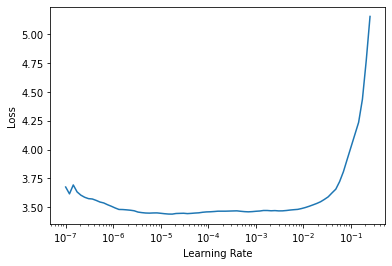

In [38]:
learn.lr_find()

In [58]:
!nvidia-smi

Sun Dec 27 19:40:56 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P0    31W /  70W |  14931MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [39]:
lr = 6e-7

In [40]:
learn.fit_one_cycle(1, lr)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.509228,3.371553,0.380893,29.123720,1:25:00


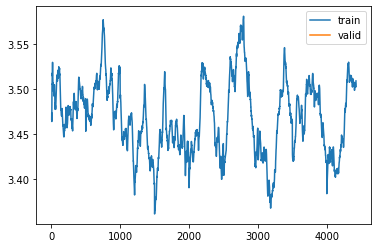

In [41]:
learn.recorder.plot_loss()

In [42]:
model = learn.model
# encode
prompt = "он посмотрел на меня"
input_ids = tokenizer.encode(prompt, return_tensors='pt').to('cuda')

### Generating 1 (Top-k sampling)

In [47]:
%%time
#set top_k = 40 and num_return_sequences = 3
sample_outputs = model.generate(input_ids, pad_token_id=50264,
                                   do_sample=True, 
                                   max_length=500, 
                                   min_length=10,
                                   top_k=40,
                                   num_return_sequences=3)

for i, sample_output in enumerate(sample_outputs):
    print(">> Generated text {}\n\n{}".format(i+1, tokenizer.decode(sample_output.tolist())))
    print('\n---')

>> Generated text 1

он посмотрел на меня сверху вниз, а я на него снизу вверх.

– Ты – мужчина, – спокойно сказал он. – И я хотел бы, чтобы на тебя обратили внимание женщины. Они были у тебя? – Я не видела его лица, но была абсолютно уверена, что он смотрел на меня.

– Я и так много внимания обратил – до самых донышек! Поэтому я и не могу тебя увидеть. Я могу только помочь тебе, но не буду. Я – мужчина, – спокойно ответил он. – А тебя это не интересует.

«Я мужчина», – хотела еще что-то сказать, но он меня перебил.

– Не слушай меня. Ты – мужчина, – не очень уверенно произнесла я. – И это тебя не касается. Ты не мужчина. Это – ты. Ты – зверь. И я боюсь, что ты не сможешь меня защитить, если я тебя не смогу защитить. И если я не стану защищать тебя – то что? – я попыталась собраться с мыслями.

«Я зверь, – думала я. – А ты зверь. Ты не сможешь защитить меня. Ты не сможешь защитить меня. И мне очень страшно за свою шкуру».

Как он догадался? Да очень просто. Он сказал мне, что я могу по

### Generating (Top-p nucleus sampling)

In [48]:
%%time
#set top_p = 0.95, top_k = 50, temperature = 0.7, repetition_penalty = 1.2 and num_return_sequences = 3
sample_outputs = model.generate(input_ids, pad_token_id=50256,
                                   do_sample=True,
                                   max_length=250, 
                                   min_length=10,
                                   repetition_penalty=1.2,
                                   temperature=0.7,
                                   top_k=50, 
                                   top_p=0.95, 
                                   num_return_sequences=3)

for i, sample_output in enumerate(sample_outputs):
    print(">> Generated text {}\n\n{}".format(i+1, tokenizer.decode(sample_output.tolist())))
    print('\n---')

>> Generated text 1

он посмотрел на меня и добавил:
- Я так понимаю, что у вас не хватает фантазии. Вы знаете о том, как это делается? 

Я кивнула. Он пожал плечами, будто мне нечего было ответить, но я все же спросила его: - Ну да… Это просто очень здорово! В чем дело?

Он усмехнулся и сказал:  - Не знаю, возможно ли такое в принципе. Но может быть, вы сможете придумать несколько вариантов, которые будут способствовать развитию вашего бизнеса... И еще… Мне бы хотелось узнать ваше мнение об этом деле. Что скажете по поводу того, чтобы сделать «проверочный выстрел» для этого проекта? Или что-то подобное?.. 

Я ответила, а он продолжил:  - Думаю, с вашей точки зрения, вам стоит подумать над этим предложением. Оно должно помочь избежать больших финансовых потерь, связанных со смертью человека или с тем, кто им управляет. Если вам повезет… Может получиться нечто вроде игры типа нашего "Супермен". Там будет много народу из разных стран и звездных войн, где люди будут вести себя соответстве

### Freeze all layers but the last 2 layers groups

In [49]:
learn.freeze_to(-2)
learn.summary()

GPT2LMHeadModel (Input shape: 8)
Layer (type)         Output Shape         Param #    Trainable 
                     8 x 1024 x 768      
Embedding                                 38602752   True      
Embedding                                 1572864    True      
Dropout                                                        
LayerNorm                                 1536       True      
____________________________________________________________________________
                     8 x 1024 x 2304     
Conv1D                                    1771776    False     
Conv1D                                    590592     False     
Dropout                                                        
Dropout                                                        
LayerNorm                                 1536       True      
____________________________________________________________________________
                     8 x 1024 x 3072     
Conv1D                                    23623

In [50]:
learn.fit_one_cycle(1, slice(3e-7/(2.6**4),3e-7))

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.513709,3.367426,0.381346,29.003780,1:26:06


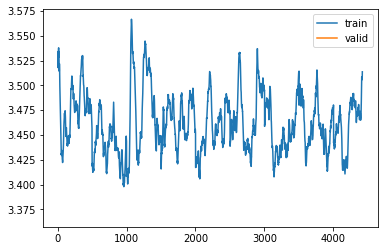

In [51]:
#hide
learn.recorder.plot_loss()

In [52]:
model_last2 = learn.model
# encode
prompt = "он посмотрел на меня"
input_ids = tokenizer.encode(prompt, return_tensors='pt').to('cuda')

### Generating (Top-k sampling)

In [53]:
%%time
#set top_k = 40 and num_return_sequences = 3
sample_outputs = model_last2.generate(input_ids, pad_token_id=50264,
                                   do_sample=True, 
                                   max_length=500, 
                                   min_length=10,
                                   top_k=40,
                                   num_return_sequences=3)

for i, sample_output in enumerate(sample_outputs):
    print(">> Generated text {}\n\n{}".format(i+1, tokenizer.decode(sample_output.tolist())))
    print('\n---')

>> Generated text 1

он посмотрел на меня с сомнением. Как ни странно, я не чувствовал себя неловко. Как только он отошел, я направился прямиком к двери. Я сел на стул и закрыл глаза, не желая снова встретиться с ним взглядом.

В комнате было много незнакомых людей; казалось, я был на вечеринке, которую они затеяли в день моего рождения. Я встал, подошел к письменному столу, на котором стоял фужер с шампанским. Сняв часы, я положил их в карман пальто. Нажав кнопку звонка, я услышал его голос.

Сняв свой пиджак, я бросил быстрый взгляд на него.

— Добрый вечер, детектив Филлипс. Вы не могли бы зайти сюда, когда я закончу? — спросил я.

— Вы знаете, что хотели бы поговорить с Филлипсом насчет моей дочери?

— Нет. Только у вас.

— Так мне удобнее.

— А если вы пойдете со мной наверх? — спросил я.

— Нет, я занят с детьми.

— А если я просто прогуляюсь, и вы придете ко мне сами, и я не могу вас беспокоить?

— Я же не работаю, мне нужно время.

— Тогда пошли.

— Что ж, тогда в другое время.

### Generating (Top-p nucleus sampling)

In [54]:
%%time
sample_outputs = model_last2.generate(input_ids, pad_token_id=50256,
                                   do_sample=True,
                                   max_length=250, 
                                   min_length=10,
                                   repetition_penalty=1.2,
                                   temperature=0.7,
                                   top_k=50, 
                                   top_p=0.95, 
                                   num_return_sequences=3)

for i, sample_output in enumerate(sample_outputs):
    print(">> Generated text {}\n\n{}".format(i+1, tokenizer.decode(sample_output.tolist())))
    print('\n---')

>> Generated text 1

он посмотрел на меня. Не мог же я так поступить! И все же, не смотря ни на что, я решил остаться с ним в палате и не терять времени зря: - Доктор? Вызовите врача к завтраку. Я уже знал о его состоянии. Он был мертв почти три месяца назад, но сейчас вновь начал жить нормальной жизнью. Его глаза сияли счастьем, а губы кривились от счастья. Да, он жив! Но… почему тогда никто из нас об этом не узнает? Я вздохнул, чувствуя себя очень виноватым за то, как мне это дается. На мгновение даже показалось, будто сам дьявол бросил меня умирать. Мне кажется, что если бы у него спросили правду, я бы ей ответил. Ведь этот человек дал ему шанс еще раз пережить смерть. Пусть лишь для того, чтобы спасти свою жизнь. Как только я произнес эти слова, ко мне пришла уверенность. Что-то изменилось во мне после этих слов. Теперь я понимаю, как глупо было думать о том, что такое любовь! По моему лицу пробежала тень. Кто знает, возможно, эта фраза была чистой правдой. В следующий момент сердц